In [2]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Add .. to the path
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
from src.models import DANN
from src.dino_mod.utils import restart_from_checkpoint
import src.dino_mod.vision_transformer as vits

In [3]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0

In [4]:
torch.random.manual_seed(SEED)
random.seed(SEED)

In [5]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}
test_images = {2: {0: None, 1: None}}

In [16]:
class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        
        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(hdf.get(img_id).get('img'))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else None
            center = np.array(hdf.get(img_id).get('metadata'))[0] if self.mode == 'train' else None
        return img.float(), label, center

In [17]:
preprocessing = None
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, preprocessing, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, preprocessing, 'train')
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)

In [18]:
def precompute(dataloader, model, device):
    xs, ys, cs = [], [], []
    n_max = 1000
    n = 0
    for x, y, c in tqdm(dataloader, leave=False, total=n_max):
        with torch.no_grad():
            xs.append(model(x.to(device)).detach().cpu().numpy())
        ys.append(y.numpy())
        cs.append(c.numpy())
        n += 1
        if n == n_max:
            break
    xs = np.vstack(xs)
    ys = np.hstack(ys)
    cs = np.hstack(cs)
    return torch.tensor(xs), torch.tensor(ys), torch.tensor(cs)

class PrecomputedDataset(Dataset):
    def __init__(self, features, labels, centers):
        super(PrecomputedDataset, self).__init__()
        self.features = features
        self.labels = labels.unsqueeze(-1)
        self.centers = centers.unsqueeze(-1)
    
    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].float(), self.centers[idx].float()

class TestDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode):
        super(TestDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        
        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return 500

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(hdf.get(img_id).get('img'))
        return img.float(), np.array(2), np.array(2)

/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


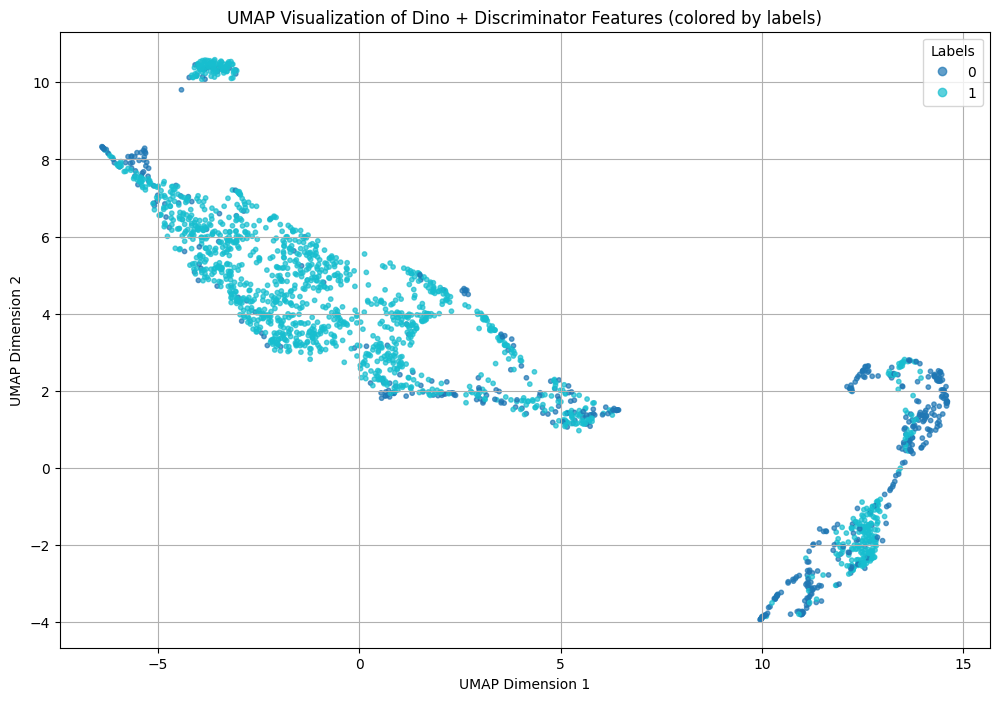

/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


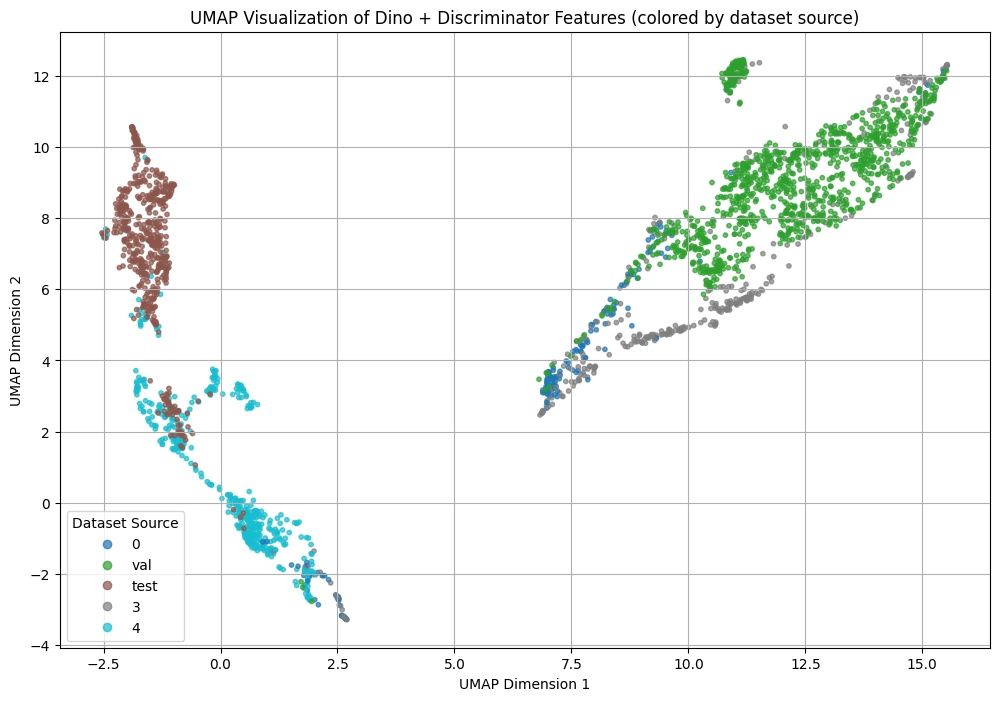

/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


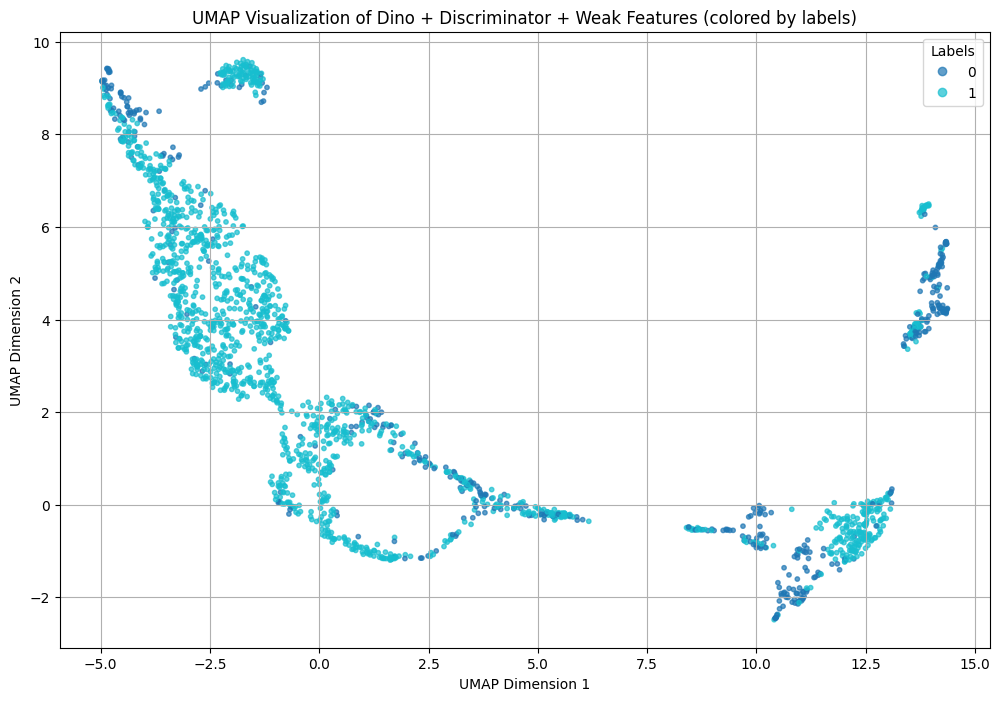

/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lu/Desktop/Universidad/MVA/2do_semestre/dlmi/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


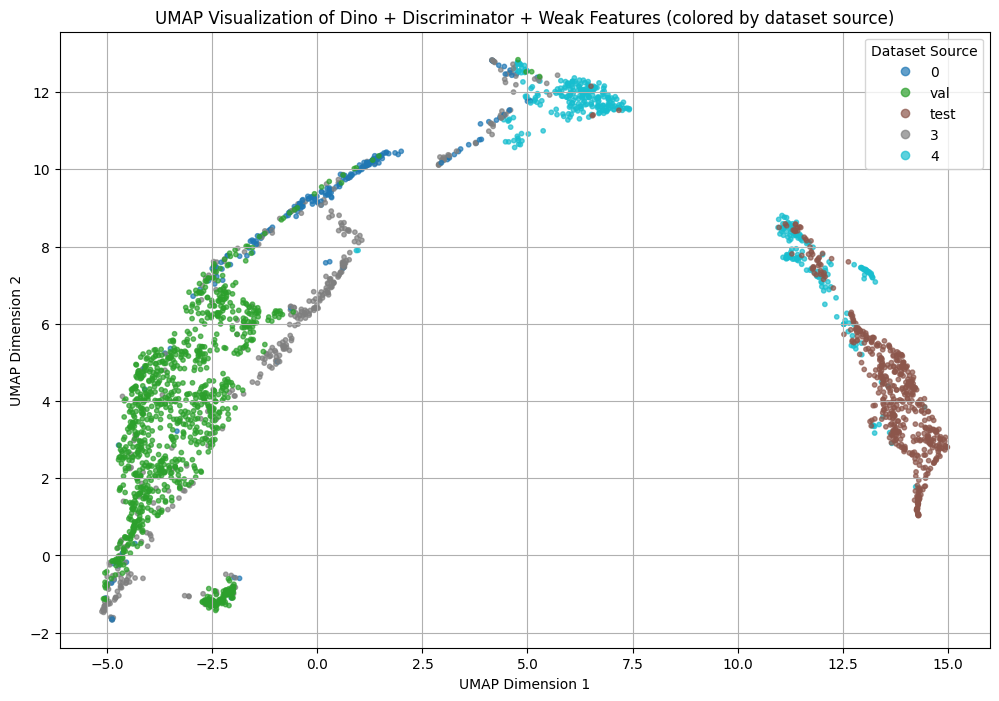

In [20]:
# Define model
backbone = vits.__dict__['vit_small'](
            patch_size=16,
            drop_path_rate=0.1,  # stochastic depth
        )

weights = ["checkpoint0010.pth", "checkpoint0010_weak.pth"]
names = ["Dino + Discriminator", "Dino + Discriminator + Weak"]
test_dataset = TestDataset(TEST_IMAGES_PATH, preprocessing, 'train')
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

for weight, name in zip(weights, names):
    restart_from_checkpoint(
            os.path.join('./weights/pre-training/', weight),
            student=backbone,
        )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    feature_extractor = backbone.to(device)
    feature_extractor.eval()

    train_dataset = PrecomputedDataset(*precompute(train_dataloader, feature_extractor, device))
    val_dataset = PrecomputedDataset(*precompute(val_dataloader, feature_extractor, device))
    test_dataset = PrecomputedDataset(*precompute(test_dataloader, feature_extractor, device))

    # Load your dataset (adjust the loading method accordingly)
    dataset = train_dataset  # adjust as needed
    dataset_val = val_dataset  # adjust as needed

    features = dataset.features.numpy()
    # Add val features
    features = np.concatenate((features, dataset_val.features.numpy()), axis=0)
    labels = dataset.labels.numpy()
    # Add val labels
    labels = np.concatenate((labels, dataset_val.labels.numpy()), axis=0)
    sources = dataset.centers.numpy()
    # Add val sources
    sources = np.concatenate((sources, dataset_val.centers.numpy()), axis=0)

    # Run UMAP on your features
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings = reducer.fit_transform(features)

    # Get handles and original numerical labels from the scatter plot

    # Plot UMAP embeddings colored by labels
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings[:, 0], embeddings[:, 1],
        c=labels, cmap="tab10", s=10, alpha=0.7
    )

    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.title(f"UMAP Visualization of {name} Features (colored by labels)")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True)
    plt.show()

    # Load your dataset (adjust the loading method accordingly)
    dataset = train_dataset  # adjust as needed
    dataset_val = val_dataset  # adjust as needed
    dataset_test = test_dataset  # adjust as needed

    features = dataset.features.numpy()
    # Add val features
    features = np.concatenate((features, dataset_val.features.numpy(), dataset_test.features.numpy()), axis=0)
    # Add val sources
    sources = np.concatenate((dataset.centers.numpy(), dataset_val.centers.numpy(), dataset_test.centers.squeeze(0).numpy()), axis=0)

    # Run UMAP on your features
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings = reducer.fit_transform(features)

    # Optional: Plot embeddings colored by dataset/source
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings[:, 0], embeddings[:, 1],
        c=sources, cmap="tab10", s=10, alpha=0.7
    )

    # Original numeric labels used in the data
    original_labels = np.unique(sources)

    # Custom label mapping
    label_map = {0: "0", 3: "3", 4: "4", 1: "val", 2: "test"}

    # Get legend handles from scatter
    handles, _ = scatter.legend_elements()

    # Map numeric labels to custom strings
    custom_labels = [label_map[label] for label in original_labels]

    # Create the legend with custom text
    plt.legend(handles=handles, labels=custom_labels, title="Dataset Source")

    plt.title(f"UMAP Visualization of {name} Features (colored by dataset source)")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True)
    plt.show()

